In [31]:
import pandas as pd
import os
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd
plt.rcParams["font.family"] = "Arial"

### decile_enrichment

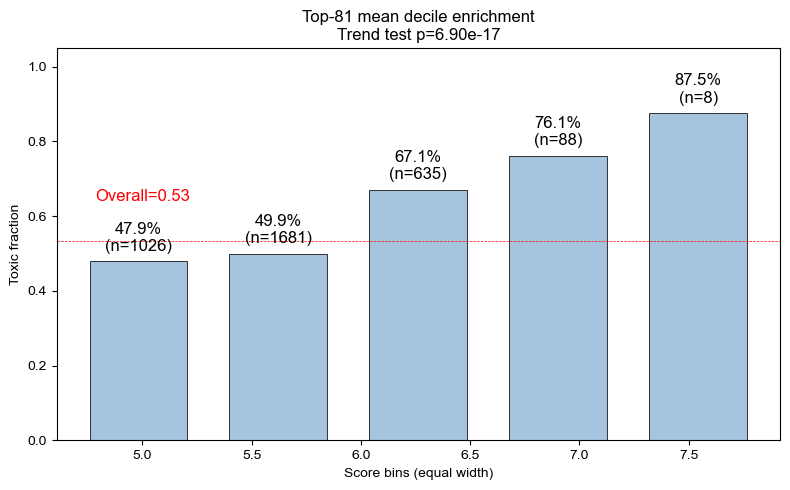

In [5]:


def wilson_ci(k, n, z=1.96):
    """Compute Wilson confidence interval for a binomial proportion."""
    if n == 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2 * n)) / denom
    half = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2)) / denom
    return center - half, center + half


def plot_decile_enrichment(y_true, y_score, n_bins=6, title=None, mode="score"):
    """
    Plot decile enrichment (or quantile enrichment) to visualize how toxicity rates 
    change across score bins.

    Parameters:
        y_true : array-like
            Binary labels (1 = toxic, 0 = non-toxic)
        y_score : array-like
            Model scores or affinity values
        n_bins : int
            Number of bins
        title : str
            Figure title
        mode : {'score', 'quantile'}
            'score' = divide by equal score width
            'quantile' = divide by quantiles
    """
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    rates, Ns, bin_idx_all, y_all = [], [], [], []

    # Split samples by quantile or equal-width bins
    if mode == "quantile":
        order = np.argsort(y_score)
        bins = np.array_split(order, n_bins)
        for b, idx in enumerate(bins, start=1):
            n = len(idx)
            k = int(y_true[idx].sum())
            p = k / n if n > 0 else np.nan
            rates.append(p)
            Ns.append(n)
            bin_idx_all.extend([b] * n)
            y_all.extend(y_true[idx])
        x = np.arange(1, n_bins + 1)

    elif mode == "score":
        bins_edges = np.linspace(y_score.min(), y_score.max(), n_bins + 1)
        for b in range(n_bins):
            idx = (y_score >= bins_edges[b]) & (y_score < bins_edges[b + 1])
            n = idx.sum()
            k = int(y_true[idx].sum())
            p = k / n if n > 0 else np.nan
            rates.append(p)
            Ns.append(n)
            bin_idx_all.extend([b + 1] * n)
            y_all.extend(y_true[idx])
        x = (bins_edges[:-1] + bins_edges[1:]) / 2

    # Trend test (logistic regression)
    if len(set(bin_idx_all)) > 1:
        X = sm.add_constant(bin_idx_all)
        model = sm.Logit(y_all, X).fit(disp=0)
        p_trend = model.pvalues[1]
    else:
        p_trend = np.nan

    # ===== Plot =====
    fig, ax = plt.subplots(figsize=(8, 5))
    bar_width = 0.7 * (x[1] - x[0] if len(x) > 1 else 0.1)

    ax.bar(
        x, rates, width=bar_width,
        color="#9EBEDC",
        alpha=0.9, edgecolor="black", linewidth=0.6
    )

    # Plot baseline (overall toxic fraction)
    base = y_true.mean()
    ax.axhline(base, ls="--", lw=0.5, color="red")
    ax.text(x.min() - 0.2, base + 0.1, f"Overall={base:.2f}", va="bottom", color="red", fontsize=12)

    # Add value labels above bars
    for xi, p, n in zip(x, rates, Ns):
        if not np.isnan(p):
            ax.text(xi, p + 0.02, f"{p * 100:.1f}%\n(n={n})", ha="center", va="bottom", fontsize=12)

    ax.set_xlabel("Score bins" + (" (quantiles)" if mode == "quantile" else " (equal width)"))
    ax.set_ylabel("Toxic fraction")
    ax.set_ylim(0, 1.05)

    # Title with trend test p-value
    if not np.isnan(p_trend):
        ax.set_title((title or "Decile enrichment") + f"\nTrend test p={p_trend:.2e}")
    else:
        ax.set_title(title or "Decile enrichment")

    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.grid(False)

    plt.tight_layout()
    plt.show()


# ===== 1) Load toxic / non-toxic data =====
df_negreg = pd.read_excel('predict_data/negative.xlsx', index_col=0)
df_posreg = pd.read_excel('predict_data/positive.xlsx', index_col=0)

# ===== 2) Merge → standardize (if needed) → split again =====
df_all = pd.concat([df_posreg, df_negreg], axis=0)
# df_all_z = zscore_by_column(df_all)  # Optional standardization step
df_posreg_z = df_all.loc[df_posreg.index]
df_negreg_z = df_all.loc[df_negreg.index]

# ===== 3) Compute Top-k mean score =====
k = 81
def mean_per_sample_ignore_zero(df, k=81):
    """
    Calculate the mean of the top-k nonzero values for each sample.
    (Zeros represent compound–target pairs already seen in the training set and are ignored.)
    """
    return df.apply(
        lambda row: (
            row[row != 0]
            .nlargest(k)
            .mean()
            if (row[row != 0].size > 0) else np.nan
        ),
        axis=1
    )

score_pos = mean_per_sample_ignore_zero(df_posreg, k=k)
score_neg = mean_per_sample_ignore_zero(df_negreg, k=k)

# ===== 4) Decile enrichment plot =====
y_true = np.r_[np.ones(len(score_pos)), np.zeros(len(score_neg))]
y_score = np.r_[score_pos.values, score_neg.values]

plot_decile_enrichment(y_true, y_score, n_bins=5, title=f"Top-{k} mean decile enrichment")


### top k

  Metric  median_Toxic  median_Non-toxic  median_diff  mean_diff       p_value
0   Top3      6.481840          6.276741     0.205099   0.216193  4.625861e-20
1   Top5      6.394555          6.172892     0.221664   0.220532  1.976804e-20
2  Top10      6.257460          6.040495     0.216965   0.222279  9.485777e-21
3  Top20      6.081704          5.895778     0.185926   0.214987  1.179538e-20
4    All      5.587178          5.431558     0.155620   0.157198  2.895789e-19


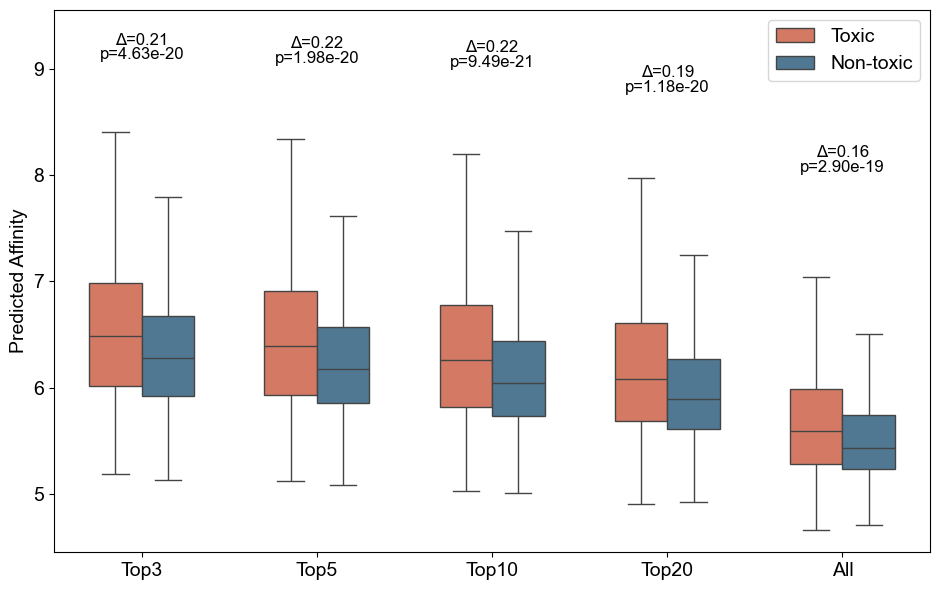

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def compute_topk_scores_ignore_zero(df, ks=[3, 5, 10, 20], include_all=True):
    """
    Compute Top-k mean scores for each row in a DataFrame, ignoring zero values.
    Zeros represent interactions already seen in the training set and are excluded.
    """
    results = {}
    for idx, row in df.iterrows():
        # Convert the row to a numpy array
        values = row.values
        # Keep only nonzero values
        nonzero_vals = values[values != 0]
        # If all values are zero, set results as NaN
        if nonzero_vals.size == 0:
            res = {f"Top{k}": np.nan for k in ks}
            if include_all:
                res["All"] = np.nan
            results[idx] = res
            continue

        # Sort nonzero values in descending order
        sorted_vals = np.sort(nonzero_vals)[::-1]

        res = {}
        for k in ks:
            # If there are fewer nonzero values than k, take the mean of all
            if sorted_vals.size >= k:
                res[f"Top{k}"] = sorted_vals[:k].mean()
            else:
                res[f"Top{k}"] = sorted_vals.mean()
        if include_all:
            # “All” = mean of all nonzero values
            res["All"] = nonzero_vals.mean()

        results[idx] = res

    return pd.DataFrame(results).T


# ====== 1) Combine and preprocess datasets ======
df_all = pd.concat([df_posreg, df_negreg], axis=0)
# df_all_z = zscore_by_column(df_all)  # optional z-score normalization
df_posreg_z = df_all.loc[df_posreg.index]
df_negreg_z = df_all.loc[df_negreg.index]

# ====== 2) Compute Top-k features ======
df_pos_feat = compute_topk_scores_ignore_zero(df_posreg); df_pos_feat["Label"] = "Toxic"
df_neg_feat = compute_topk_scores_ignore_zero(df_negreg); df_neg_feat["Label"] = "Non-toxic"
df_feat = pd.concat([df_pos_feat, df_neg_feat])

plt.figure(figsize=(9.5, 6))

# ====== 3) Prepare data for visualization ======
melted = df_feat.melt(id_vars="Label", var_name="Metric", value_name="Affinity")

# Soft red–blue color palette
palette = {"Toxic": "#e76f51", "Non-toxic": "#457b9d"}

# ====== 4) Draw boxplots ======
ax = sns.boxplot(
    data=melted, x="Metric", y="Affinity", hue="Label",
    palette=palette, width=0.6, fliersize=0   # Hide outliers
)

# ====== 5) Statistical testing and annotations (Mann–Whitney U test + median difference) ======
# Use the actual axis order to avoid mismatch with seaborn’s internal ordering
metrics_order = [t.get_text() for t in ax.get_xticklabels()]

ymin, ymax = ax.get_ylim()
yrange = ymax - ymin if np.isfinite(ymax - ymin) else 1.0
pad = 0.03 * yrange  # vertical spacing for annotations

rows = []
for i, metric in enumerate(metrics_order):
    g = melted["Metric"] == metric
    group_toxic = melted[g & (melted["Label"] == "Toxic")]["Affinity"].dropna()
    group_non   = melted[g & (melted["Label"] == "Non-toxic")]["Affinity"].dropna()

    # Mann–Whitney U test
    if len(group_toxic) > 0 and len(group_non) > 0:
        stat, pval = mannwhitneyu(group_toxic, group_non, alternative="two-sided")
    else:
        stat, pval = np.nan, np.nan

    # Compute mean and median differences (Toxic - Non-toxic)
    mean_tox = group_toxic.mean() if len(group_toxic) else np.nan
    mean_non = group_non.mean() if len(group_non) else np.nan
    mean_diff = mean_tox - mean_non
    med_toxic = group_toxic.median() if len(group_toxic) else np.nan
    med_non   = group_non.median() if len(group_non) else np.nan
    median_diff = med_toxic - med_non

    rows.append({
        "Metric": metric,
        "median_Toxic": med_toxic,
        "median_Non-toxic": med_non,
        "median_diff": median_diff,
        "mean_diff": mean_diff,
        "u_stat": stat,
        "p_value": pval
    })

    # Annotation position (above the highest value in the group)
    group_max = pd.concat([group_toxic, group_non], axis=0).max()
    base_y = (group_max if np.isfinite(group_max) else ymax) + pad

    # Annotate p-value and Δ (median difference)
    if pd.notna(pval):
        ax.text(i, base_y, f"p={pval:.2e}",
                ha="center", va="bottom", fontsize=12, color="black")
    if pd.notna(median_diff):
        ax.text(i, base_y + pad, f"Δ={median_diff:.2f}",
                ha="center", va="bottom", fontsize=12, color="black")

# Expand upper y-limit to prevent overlap with annotations
ax.set_ylim(ymin, max(ax.get_ylim()[1], ymax + 3 * pad))

# Output median and difference summary table
median_diff_df = pd.DataFrame(rows)
print(median_diff_df[["Metric", "median_Toxic", "median_Non-toxic", "median_diff", "mean_diff", "p_value"]])

# Clean legend and styling
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], title="Group", loc="upper right")
ax.set_xlabel("")
ax.set_ylabel("Predicted Affinity", fontsize=14)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc="upper right", bbox_to_anchor=(1, 1), frameon=True, fontsize=14)
plt.grid(False)
plt.savefig('boxplot_topk_comparison.svg')
plt.tight_layout()
plt.show()


### 排序

回归结果差异: p = 1.4478943193313592e-19
(1831,)


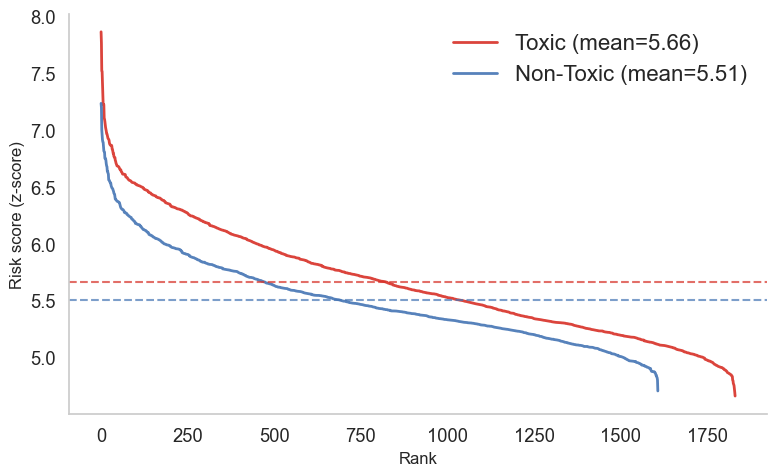

In [28]:
# Ranking plot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu

# Set global plotting style
sns.set(style="whitegrid", font_scale=1.2)

def plot_ranking_two(scores_pos, scores_neg):
    """Plot ranking curves comparing two groups (toxic vs non-toxic)."""

    # Sort scores in descending order
    scores_pos_sorted = np.sort(scores_pos.values)[::-1]
    scores_neg_sorted = np.sort(scores_neg.values)[::-1]

    # Mann–Whitney U test (one-sided: Toxic > Non-Toxic)
    stat, p = mannwhitneyu(scores_pos_sorted, scores_neg_sorted, alternative="greater")
    print("Regression score difference: p =", p)

    # Mean values
    mean_pos = np.mean(scores_pos)
    mean_neg = np.mean(scores_neg)

    # Plot ranking curves
    plt.figure(figsize=(8, 5))
    plt.plot(
        scores_pos_sorted,
        label=f"Toxic (mean={mean_pos:.2f})",
        color="#d73027", lw=2, alpha=0.9
    )
    plt.plot(
        scores_neg_sorted,
        label=f"Non-Toxic (mean={mean_neg:.2f})",
        color="#4575b4", lw=2, alpha=0.9
    )

    # Add horizontal lines for group means
    plt.axhline(mean_pos, color="#d73027", linestyle="--", alpha=0.7)
    plt.axhline(mean_neg, color="#4575b4", linestyle="--", alpha=0.7)

    # Axis labels and aesthetics
    # plt.title(f"Ranking Plot - {title}", fontsize=15, fontweight="bold")
    plt.xlabel("Rank", fontsize=12)
    plt.ylabel("Risk score (z-score)", fontsize=12)
    plt.legend(frameon=False, fontsize=16, loc="upper right")
    sns.despine()
    plt.grid(False)
    
    plt.tight_layout()
    plt.show()


# Compute per-sample mean ignoring zeros
df_negmean = mean_per_sample_ignore_zero(df_negreg)
df_posmean = mean_per_sample_ignore_zero(df_posreg)

# Generate the ranking plot
plot_ranking_two(df_posmean, df_negmean)


回归结果差异: p = 5.588954281312411e-20
(1831,)


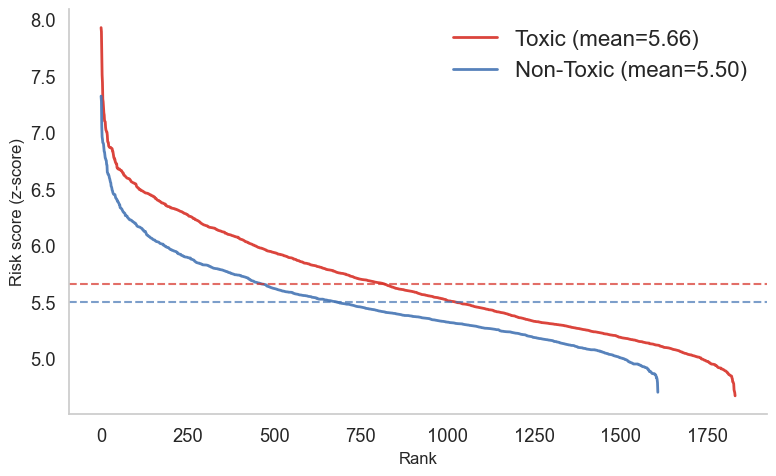

In [29]:
import pandas as pd
df_tar = pd.read_csv('bio_target.csv')
biotar = df_tar['task'].tolist()
df_negregbio = df_negreg.loc[:,biotar]
df_posregbio = df_posreg.loc[:,biotar]
df_negmeanbio = mean_per_sample_ignore_zero(df_negregbio)
df_posmeanbio = mean_per_sample_ignore_zero(df_posregbio)

plot_ranking_two(df_posmeanbio, df_negmeanbio)